In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re 
import random
import string


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score 
from sklearn.ensemble import RandomForestClassifier


import tensorflow
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation
from tensorflow.keras.layers import Embedding


!pip install nltk
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import ngrams
from nltk.probability import FreqDist

# Download necessary NLTK data files
nltk.download('punkt')
nltk.download('stopwords')
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2024-08-02 22:21:45.357628: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-02 22:21:45.357771: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-02 22:21:45.493137: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/kaggle/input/daigt-proper-train-dataset/train_drcat_03.csv
/kaggle/input/daigt-proper-train-dataset/train_drcat_02.csv
/kaggle/input/daigt-proper-train-dataset/train_drcat_04.csv
/kaggle/input/daigt-proper-train-dataset/train_drcat_01.csv
/kaggle/input/dailydialog-unlock-the-conversation-potential-in/validation.csv
/kaggle/input/dailydialog-unlock-the-conversation-potential-in/train.csv
/kaggle/input/dailydialog-unlock-the-conversation-potential-in/test.csv


## 0. GloVe Embdeing
---

### download ...

In [2]:
# download stanford GloVe
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2024-08-02 22:22:10--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-08-02 22:22:10--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-08-02 22:22:11--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: 'glove.6B.zip'

glov

In [3]:
embedding_dim = 300
def load_glove_model(glove_file):
    print("Loading GloVe Model...")
    model = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array([float(val) for val in split_line[1:]])
            model[word] = embedding
            
    model["<unk>"] = np.array([float(0) for _ in range(embedding_dim)] )
    print("Done.", len(model), " words loaded!")
    return model

glove_model = load_glove_model(f"glove.6B.{str(embedding_dim)}d.txt")  


Loading GloVe Model...
Done. 400001  words loaded!


In [4]:
word_index = list(glove_model.keys())
vocab_size = len(word_index)

### embeding matrix

In [5]:
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for i in range(len(word_index)):
    embedding_matrix[i] =  glove_model.get(word_index[i])


## 1. Data
---

In [6]:

data1 = pd.read_csv("/kaggle/input/daigt-proper-train-dataset/train_drcat_01.csv", usecols =["text"])
data2 = pd.read_csv("/kaggle/input/daigt-proper-train-dataset/train_drcat_02.csv", usecols =["text"])
data3 = pd.read_csv("/kaggle/input/daigt-proper-train-dataset/train_drcat_03.csv", usecols =["text"])
data4 = pd.read_csv("/kaggle/input/daigt-proper-train-dataset/train_drcat_04.csv", usecols =["text"])


train_data = pd.concat([data1,data2,data3,data4])

train_data.head()

,text
0,There are alot reasons to keep our the despise...
1,Driving smart cars that drive by themself has ...
2,"Dear Principal,\n\nI believe that students at ..."
3,"Dear Principal,\n\nCommunity service should no..."
4,My argument for the development of the driverl...


In [7]:
train_data = train_data.dropna()
data_size = len(train_data.text)

In [8]:
def data_processing(data, word_index=word_index, ngram=4):
    def preprocess_text(text):
        text = re.sub(r"[^A-Za-z0-9\s]", "", text)
        tokens = word_tokenize(text.lower())
        return [word_index.index(token) if token in word_index else word_index.index("<unk>") for token in tokens]

    X, Y = [], []
    for row in data:
        sentence = preprocess_text(row)
        ng = list(ngrams(sentence, ngram))
        X.extend([gram[:-1] for gram in ng])
        Y.extend([gram[-1] for gram in ng])
    return np.array(X), np.array(Y)

## 3. Model

In [9]:
model = Sequential ([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              trainable=False),
    LSTM(256,return_sequences=True),
    Dropout(0.2),
    LSTM(128,return_sequences=False),
    Dropout(0.2),
    Dense(200, activation='relu'),
    Dropout(0.2),
    Dense(vocab_size, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


### training


In [10]:
history = []

def train(epochs =10,sample_size=0.1):
    global history,data_size
    if sample_size>data_size-1 :
        print("too large sample size")
        return 
    if sample_size>1:
        r = random.randint(0,data_size-sample_size)
    elif 0<sample_size <= 1:
        sample_size = int(sample_size * data_size)
        print("sample_size : ",sample_size)
        r = random.randint(0,data_size-sample_size)
    else: 
        print("invalid parameters")
        return 
        
    sample_x,sample_y = data_processing(train_data.text[r:r+sample_size])
    his = model.fit(sample_x,sample_y,epochs = epochs ,validation_split=0.2)
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    ax[0].plot(his.history['accuracy'])
    ax[0].plot(his.history['val_accuracy'])
    ax[0].legend(['accuracy', 'val'], loc='upper left')

    ax[1].plot(his.history['loss'])
    ax[1].plot(his.history['val_loss'])
    ax[1].legend(['loss', 'val_loss'], loc='upper left')

    plt.show()
    
#     history.append(his.history)

In [11]:
# Verify GPU is available
print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))

Num GPUs Available:  1


sample_size :  15
Epoch 1/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 45s 277ms/step - accuracy: 0.0797 - loss: 6.9527 - val_accuracy: 0.1038 - val_loss: 5.8946
Epoch 2/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 44s 277ms/step - accuracy: 0.1168 - loss: 5.9002 - val_accuracy: 0.1140 - val_loss: 5.8049
Epoch 3/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 44s 277ms/step - accuracy: 0.1314 - loss: 5.5369 - val_accuracy: 0.1124 - val_loss: 5.8573
Epoch 4/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 45s 277ms/step - accuracy: 0.1392 - loss: 5.3324 - val_accuracy: 0.1155 - val_loss: 5.9303
Epoch 5/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 44s 277ms/step - accuracy: 0.1561 - loss: 5.1366 - val_accuracy: 0.1226 - val_loss: 6.0374
Epoch 6/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 44s 277ms/step - accuracy: 0.1637 - loss: 4.8886 - val_accuracy: 0.1241 - val_loss: 6.1000
Epoch 7/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 44s 277ms/step - accuracy: 0.1678 - loss: 4.8041 - val_accuracy: 0.1210 - val_loss: 6.2680
Epoch 8/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 45s 277ms/step - accuracy

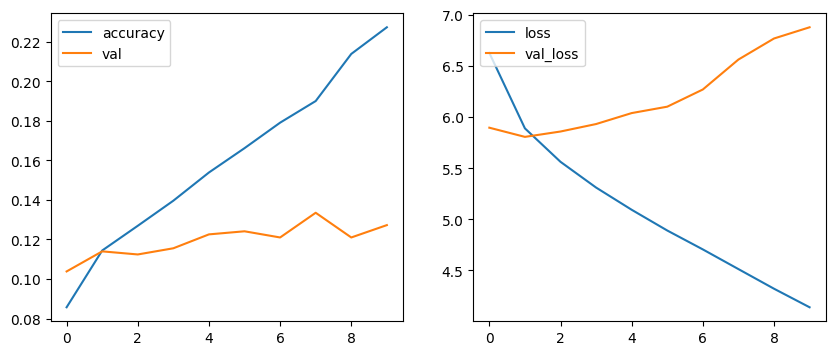

In [37]:
train(sample_size=0.0001)

### prediction

In [32]:

def pred(words,lenght=100):
    word_arr = list(words.split())
    indexs = [word_index.index(w.lower()) for w in word_arr ]
    vec = np.array(indexs).reshape(1,3,1)
    prd = np.argmax(model.predict(vec,verbose=0))
    prd = word_index[prd] 
    
    
    return prd

In [33]:

cnt = 0
arr = ["my","name",'is']
print(arr[0],arr[1],end=" ")
while cnt<100:
    prd = pred(" ".join(arr))
    arr[0] = arr[1]
    arr[1] = prd
    cnt +=1
    print(prd,end=" ")

my name <unk> very a more more a more more a more more a more more a more more a more more a more more a more more a more more a more more a more more a more more a more more a more more a more more a more more a more more a more more a more more a more more a more more a more more a more more a more more a more more a more more a more more a more more a more more a more more a more more a more more a more 

### Note : 
This model requires a large amount of data to function as expected. It is intended for learning purposes only.
